Below goes some simple solutions to some small headaches one can find using Xarray and Cartopy. The first is how to get rid of the white line in the middle of your plot and the second is to cross the greenwich meridian nicely.

In [22]:
import matplotlib.pyplot   as plt
import cartopy.crs         as ccrs
import cartopy.feature     as cf
import cartopy             as cartopy
import numpy               as np
import xarray              as xr

from cartopy.mpl.ticker    import LongitudeFormatter, LatitudeFormatter
from cartopy.util 		   import add_cyclic_point

In [23]:
dset  =  xr.open_dataset('sst.mnmean.nc')
var   =  dset['sst'][:,:,:]

In [24]:
lat1  =  30. ; lat2  =  -30. ; lon1  =  0. ; lon2  =  360. 

In [25]:
lat  =  var.sel(lat=slice(lat1,lat2)) 
lat  =  np.asarray(lat.lat.values)

lon  =  var.sel(lon=slice(lon1,lon2))
lon  =  np.asarray(lon.lon.values)

var  =  var.sel(lat=slice(lat1,lat2), lon=slice(lon1,lon2))

print (lat.shape, lon.shape, var.shape)

(31,) (180,) (1965, 31, 180)


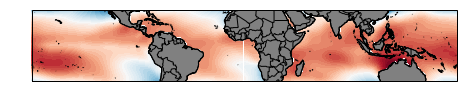

In [26]:
plt.figure(figsize=(8,4))
proj  =  ccrs.PlateCarree()
ax = plt.axes(projection=proj)

ax.add_feature(cf.LAND,color='grey')          
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
ax.coastlines(resolution='50m',color='black')

plt.contourf(lon, lat, var[0,:,:], 60,
             transform=proj,
             cmap=plt.get_cmap('RdBu_r'))
plt.show()

 And there it is, that weird white line right at the 0 degrees of longitude. If you're familiar with GrADS or something this problem is likely not to appear at all and it's quite simple to cross the greenwich meridian with impunity (and without the unnatractive white line). 
 
 This is clearly not the case with both Cartopy and Xarray. However, the solution to the line problem is quite simple and involves the use of the "add_cyclic_point" function (the name says it all).

In [28]:
## add cyclic point to longitude array
lon_idx = var.dims.index('lon')
var_c, lon_c = add_cyclic_point(var.values, 
								coord=lon, axis=lon_idx)

Concerning the longitude arrays defined, we have:

In [29]:
print (lon.shape, lon_c.shape)

(180,) (181,)


And there you go, point added. Now the difficulty is to plot again.

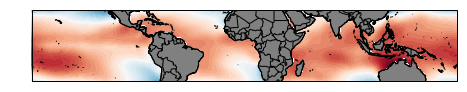

In [30]:
plt.figure(figsize=(8,4))
proj  =  ccrs.PlateCarree()
ax = plt.axes(projection=proj)

ax.add_feature(cf.LAND,color='grey')          
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
ax.coastlines(resolution='50m',color='black')

plt.contourf(lon_c, lat, var_c[0,:,:], 60,
             transform=proj,
             cmap=plt.get_cmap('RdBu_r'))
plt.show()

How lovely.

Now, the next issue is: suppose you only want to study the Atlantic ocean, how would you slice beyond the last longitude point? You can't do something like "lon 300 400" as GrADS would allow you to do, since that won't work for Xarray.


Luckily there's a rolling method for this kind of job, which will be demonstrated now.

In [32]:
lon   =  dset['lon'][:] 
lonr = lon.roll(lon=300)

print (lonr)

<xarray.DataArray 'lon' (lon: 180)>
array([ 120.,  122.,  124.,  126.,  128.,  130.,  132.,  134.,  136.,  138.,
        140.,  142.,  144.,  146.,  148.,  150.,  152.,  154.,  156.,  158.,
        160.,  162.,  164.,  166.,  168.,  170.,  172.,  174.,  176.,  178.,
        180.,  182.,  184.,  186.,  188.,  190.,  192.,  194.,  196.,  198.,
        200.,  202.,  204.,  206.,  208.,  210.,  212.,  214.,  216.,  218.,
        220.,  222.,  224.,  226.,  228.,  230.,  232.,  234.,  236.,  238.,
        240.,  242.,  244.,  246.,  248.,  250.,  252.,  254.,  256.,  258.,
        260.,  262.,  264.,  266.,  268.,  270.,  272.,  274.,  276.,  278.,
        280.,  282.,  284.,  286.,  288.,  290.,  292.,  294.,  296.,  298.,
        300.,  302.,  304.,  306.,  308.,  310.,  312.,  314.,  316.,  318.,
        320.,  322.,  324.,  326.,  328.,  330.,  332.,  334.,  336.,  338.,
        340.,  342.,  344.,  346.,  348.,  350.,  352.,  354.,  356.,  358.,
          0.,    2.,    4.,    6.,    8.

What we did was to turn around the longitude array (an xarray object, as it won't work for numpy objects, so beware) in such a way as to allow us to slice it.

In [33]:
lonr = lon.roll(lon=300)
lonr = lonr.sel(lon=slice(290.,20.))
lonrnp = np.asarray(lonr)
new_lons = lonrnp.copy()
new_lons[1:] += np.cumsum(np.diff(lonrnp) < -180) * 360

var  =  var.sel(lat=slice(lat1,lat2),
				lon=lonr)


lon_idx = var.dims.index('lon')
var_c, lon_c = add_cyclic_point(var.values, 
								coord=new_lons, axis=lon_idx)

In [34]:
print (lonr)

<xarray.DataArray 'lon' (lon: 46)>
array([ 290.,  292.,  294.,  296.,  298.,  300.,  302.,  304.,  306.,  308.,
        310.,  312.,  314.,  316.,  318.,  320.,  322.,  324.,  326.,  328.,
        330.,  332.,  334.,  336.,  338.,  340.,  342.,  344.,  346.,  348.,
        350.,  352.,  354.,  356.,  358.,    0.,    2.,    4.,    6.,    8.,
         10.,   12.,   14.,   16.,   18.,   20.], dtype=float32)
Coordinates:
  * lon      (lon) float32 290.0 292.0 294.0 296.0 298.0 300.0 302.0 304.0 ...
Attributes:
    units:               degrees_east
    long_name:           Longitude
    actual_range:        [   0.  358.]
    standard_name:       longitude
    axis:                X
    coordinate_defines:  center


So 'lonr' is your brand new sliced longitude array, which you can now use it to happily plot over the Atlantic ocean in all it's blueness.

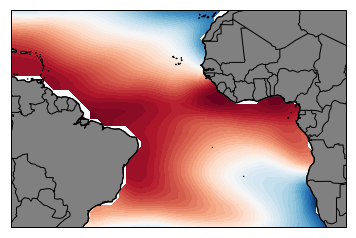

In [35]:
plt.figure(figsize=(8,4))
proj  =  ccrs.PlateCarree()
ax = plt.axes(projection=proj)

ax.add_feature(cf.LAND,color='grey')          
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
ax.coastlines(resolution='50m',color='black')

plt.contourf(lon_c, lat, var_c[0,:,:], 60,
             transform=proj,
             cmap=plt.get_cmap('RdBu_r'))
plt.show()

How lovely, again.


We went through all of this just to have this thing sliced, what a pain in the ass! Let us hope things will get easier in the future.